<a href="https://colab.research.google.com/github/sergiosb99/SSJ_SupervisedLearning/blob/Novelty/Dengue_Upgrade_Cities_Years.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **0. Introduction**


We will use the data from the competition to predict the evolution of Dengue Disease in both Iquitos and San Juan. More information in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

The objective of the exercise is to solve a regression problem and on the other hand to participate in a data competition.


# **1. Libraries**

Before starting any analysis we must ensure that the basic and general use libraries (numpy, pandas, etc.) are correctly imported. 

In [1]:
# Loading the data
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import io
from google.colab import files

# Graphics display
import seaborn as sns
import matplotlib.pyplot as plt

# Estimator and model selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Others
import numpy as np    
from sklearn.metrics import mean_absolute_error 

# **2. Loading the data**

The first step is to upload all the CSV files that have been provided to us and that thanks to them we will obtain the data with which we are going to work. To do this, we will use the tools that Google Colab offers us when uploading files.

## **Preprocessing the data**

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, etc.

We first load the datasets, and merge them in one, named train.

In [2]:
train_feat = pd.read_csv('dengue_features_train.csv')

In [3]:
train_labels = pd.read_csv('dengue_labels_train.csv')

In [4]:
train = pd.merge(train_feat,train_labels,on=['city','year','weekofyear'])

We upload the test dataset in order to know how good our model is.

In [5]:
test = pd.read_csv('dengue_features_test.csv')

We fill the Nan values:

In [6]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

In [7]:
train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


We are going to select this features for our training:

In [8]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']

Now, we want to know if there are some years that could make noise, so we obtain the mean of cases per each year.

In [9]:
train.groupby('year')['total_cases'].mean()

year
1990     24.742857
1991     53.865385
1992     45.596154
1993     22.230769
1994    125.634615
1995     25.634615
1996     16.442308
1997     27.961538
1998     88.365385
1999     31.403846
2000      6.358974
2001     14.201923
2002     11.115385
2003     10.221154
2004     12.000000
2005     20.346154
2006      9.480769
2007     22.442308
2008     13.144928
2009      6.230769
2010      8.576923
Name: total_cases, dtype: float64

As we can see, there are years with few cases, and others with much more, over the mean.

However, in order to make the selection of the years that may be eliminated, we divide the information depending on the city of the case.

First we obtain all the cases from San Juan:

In [10]:
df_sj = train[train['city']=='sj']
df_sj

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
934,sj,2008,16,2008-04-15,0.001800,-0.052750,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3


Now from Iquitos:

In [11]:
df_iq = train[train['city']=='iq']
df_iq

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


Now we can know what year is different from the others depending on the city.

San Juan:

In [12]:
df_sj.groupby('year')['total_cases'].mean()

year
1990     24.742857
1991     53.865385
1992     45.596154
1993     22.230769
1994    125.634615
1995     25.634615
1996     16.442308
1997     27.961538
1998     88.365385
1999     31.403846
2000      9.461538
2001     28.134615
2002      8.692308
2003     18.250000
2004     11.730769
2005     34.711538
2006     10.576923
2007     37.865385
2008      6.235294
Name: total_cases, dtype: float64

In [14]:
df_sj.groupby('year')['total_cases'].count()

year
1990    35
1991    52
1992    52
1993    52
1994    52
1995    52
1996    52
1997    52
1998    52
1999    52
2000    52
2001    52
2002    52
2003    52
2004    52
2005    52
2006    52
2007    52
2008    17
Name: total_cases, dtype: int64

Iquitos:

In [13]:
df_iq.groupby('year')['total_cases'].mean()

year
2000     0.153846
2001     0.269231
2002    13.538462
2003     2.192308
2004    12.269231
2005     5.980769
2006     8.384615
2007     7.019231
2008    15.403846
2009     6.230769
2010     8.576923
Name: total_cases, dtype: float64

In [15]:
df_iq.groupby('year')['total_cases'].count()

year
2000    26
2001    52
2002    52
2003    52
2004    52
2005    52
2006    52
2007    52
2008    52
2009    52
2010    26
Name: total_cases, dtype: int64

From San Juan, we are going to delete all the years with less than 11 cases as mean (11 included). From Iquitos, remove the years with almost no cases, and also 2003.

In [ ]:
#San Juan
df_sj.drop(df_sj[df_sj['year']==2000].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2002].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2004].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2006].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2008].index,inplace=True)

#Iquitos
df_iq.drop(df_iq[df_iq['year']==2000].index,inplace=True)
df_iq.drop(df_iq[df_iq['year']==2001].index,inplace=True)
df_iq.drop(df_iq[df_iq['year']==2003].index,inplace=True)

# **3. Detaching the dataset**

To train the models that we make, it is necessary to separate our training dataset into two parts, one precisely to train the model, and another to check if our models are good.

In this case, we are going to use two differents models and differents datasets, so we need to split both datasets.

In [ ]:
X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(df_sj[selected_features], df_sj['total_cases'], test_size=0.2, random_state=1)

In [ ]:
X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(df_iq[selected_features], df_iq['total_cases'], test_size=0.2, random_state=1)

#**4. Execution of the algorithm**

The decision tree creates regression models in the form of a tree structure. It will transform our dataset into smaller and smaller subsets while at the same time gradually developing an associated decision tree.

In [ ]:
def RandomForest(X_train, X_test,y_train,y_test,n_e,m_depth):
    #1.1 Model Parametrization 
    regressor = RandomForestRegressor(n_estimators= n_e, max_depth = m_depth, criterion='mae', random_state=0)
    #1.2 Model construction
    regressor.fit(X_train, y_train)
    # Test
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_test,y_pred)
    print ("Error Measure ",  mae, "\n")
    xx = np.stack(i for i in range(len(y_test)))
    plt.scatter(xx, y_test, c='r', label='data')
    plt.plot(xx, y_pred, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("RandomForests Regressor")

    plt.show()
    return regressor

We run the algorithm with the data from San Juan:

Error Measure  28.548762237762237 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


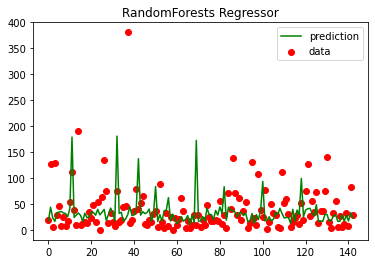

In [ ]:
model_sj = RandomForest(X_train_sj, X_test_sj,y_train_sj,y_test_sj,500,4)


We run the algorithm with the data from Iquitos:

Error Measure  6.628397435897436 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


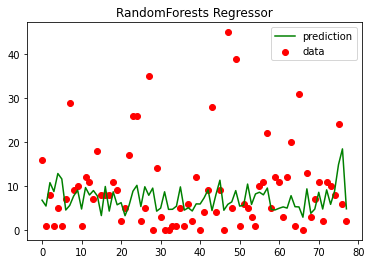

In [ ]:
model_iq = RandomForest(X_train_iq,X_test_iq,y_train_iq,y_test_iq,500,4)

# **Submission result**

Now, we are going to test our model with the data provided to us in the dengue_features_test.csv file to predict dengue cases for the weeks proposed in said file.

As we have two models, we have to predict two times, so the test dataset must be splitted in two, depending on the city.

Cases from San Juan:

In [ ]:
sj_test = test[test['city']=='sj']
sj_test

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.01890,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.01800,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.00150,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,-0.00150,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.05680,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,sj,2013,13,2013-03-26,-0.08740,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,296.4,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
256,sj,2013,14,2013-04-02,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
257,sj,2013,15,2013-04-09,-0.11760,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,297.5,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4
258,sj,2013,16,2013-04-16,0.08275,0.031200,0.135014,0.074857,0.00,298.912857,299.064286,294.678571,300.9,297.3,1.40,77.674286,0.00,15.965714,3.042857,27.728571,6.942857,31.7,23.9,22.9


Cases from Iquitos:

In [ ]:
iq_test = test[test['city']=='iq']
iq_test

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700,8.480,32.2,21.8,34.1


We predict with the cases from San Juan:

In [ ]:
final_model_prediction_sj = model_sj.predict(sj_test[selected_features])

And now with the cases from Iquitos:

In [ ]:
final_model_prediction_iq = model_iq.predict(iq_test[selected_features])

We put together both results in order to obtain the final result:

In [ ]:
final_model_prediction = np.concatenate((final_model_prediction_sj,final_model_prediction_iq))

Finally we try to visualize how our prediction has turned out with reality.

In [ ]:
# round the result and cast to int
y = np.rint(final_model_prediction) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 20,  20,  23,  32,  21,  49,  25,  30,  29,  32,  27,  39,  31,
        29,  44,  36,  36,  41, 116,  64,  45,  33,  46,  31,  31,  27,
        27,  34,  29,  29,  31,  18,  18,  18,  18,  18,  18,  18,  18,
        21,  18,  18,  18,  18,  18,  18,  19,  18,  18,  18,  18,  15,
        15,  17,  40,  29,  35,  28,  28,  30,  36,  54,  33,  39,  35,
        35,  41,  32,  39,  43,  33,  39,  31,  33,  43,  43,  43,  38,
        30,  43,  24,  37,  32,  28,  23,  35,  28,  28,  32,  21,  33,
        30,  22,  17,  19,  17,  25,  32,  21,  28,  25,  15,  17,  30,
        35,  32,  29,  30,  34, 173,  90,  39,  42,  55, 179, 180,  53,
        91,  40, 127,  83, 137, 139, 134, 146,  38,  42,  44, 140,  37,
        29,  24,  32,  29,  17,  18,  25,  31,  18,  18,  22,  21,  22,
        18,  18,  18,  18,  18,  22,  18,  20,  18,  18,  24,  18,  18,
        17,  30,  18,  38,  36,  38,  45, 177, 150,  57,  52,  51,  36,
       133,  43, 179,  50, 179,  55,  39,  44,  38,  52,  51,  3

3. We build the output file


In [ ]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])


submission.total_cases = res.astype(np.int64)
submission.to_csv("result.csv")

**And the result is:**

26.1899
Woo! I scored 26.1899 on 'DengAI: Predicting Disease Spread'!